In [1]:
import os
import pandas as pd
import numpy as np
import sys
from collections import OrderedDict
from IPython.display import display
import matplotlib.pyplot as plt
from numba import jit, prange, njit, config

sys.setrecursionlimit(100000)

from numba.typed import Dict, List

from scripts import calculate_all_fitnesses, calculate_fitness, genotype_hash,deep_copy_genotype, mutate_genotype_inplace, assert_equality_of_hashes
from scripts import test_mutation, test_fitness, test_crossover, test_selection_tournament, test_evaluate
from scripts import random_int, NODE_TYPE, GENOTYPE_TYPE, best_n_items, create_full_tree_from_genome, seed
from scripts import create_n_genotypes, crossover_numba, selection_tournament
from tqdm.notebook import tqdm



# TODO

* Parametrizar o tamanho da seleção com lexicase
* Criar função de rodar experimentos para arquivo
* Extrair as funções do arquivo scripts.py
* Falar da implentação de lexicase
* Falar do cache
* Documentar os arquivos e funções
* Executar testes nesse notebook, extraindo a função main aqui pra dentro

In [2]:
import json

# Define the name of your cache file
cache_file = "cache.csv"

cache = None
# Create an empty DataFrame if cache file doesn't exist
if not os.path.isfile(cache_file):
    cache = pd.DataFrame(columns=["file","population_size", "generations", "final_fitness", "final_std",  "p_mutation", "p_crossover", "elite_percentage", "tournament_size", "max_depth", "mean_stats", "best_gen_stats", "stds", "std_last_gen", "grammar"])
else:
    # If cache file exists, read it into a DataFrame
    cache = pd.read_csv(cache_file)

def convert_to_primitives(data):
    
    if isinstance(data, np.ndarray):
        return data.tolist()
    if isinstance(data, Dict):
        temp = {}
        for k, v in data.items():
            converted_k = convert_to_primitives(k)
            converted_v = convert_to_primitives(v)
            temp[converted_k] = converted_v
        return temp
    if isinstance(data, List):
        temp = []
        for item in data:
            converted_item = convert_to_primitives(item)
            temp.append(converted_item)
        return temp
    return data
    
def serialize_data(data):
    # check if np array
    temp = convert_to_primitives(data)
    
    return json.dumps(temp)

def load_cache(cache_df, file, run_parameters):
    mutation_rate = run_parameters['p_mutation']
    crossover_rate = run_parameters['p_crossover']
    elite_percentage = run_parameters['elite_percentage']
    tournament_size = run_parameters['tournament_size']
    population_size = run_parameters['population_size']
    generations = run_parameters['generations']
    max_depth = run_parameters['max_depth']

    cache_df["p_mutation"] = np.round(cache_df["p_mutation"], 2)
    # Filter DataFrame based on conditions
    cache_result = cache_df.query(
        f'file == "{file}" and '
        f'population_size == {population_size} and '
        f'generations == {generations} and '
        f'p_mutation == {round(mutation_rate, 2)} and '
        f'elite_percentage == {elite_percentage} and '
        f'tournament_size == {tournament_size} and '
        f'max_depth == {max_depth}'
    )
    
    # Check if there's a match
    if not cache_result.empty:
        # Extract the first match
        result = cache_result.iloc[0]
        mean_stats = json.loads(result['mean_stats'])
        best_gen_stats = json.loads(result['best_gen_stats'])
        stds = np.array(json.loads(result['stds']))
        grammar = json.loads(result['grammar'])
        print("Loaded from cache")
        #display(cache_result)
   
        return mean_stats, best_gen_stats, stds, grammar
    else:
        return None


def save_cache(cache_df, data, final_fitness, file, run_parameters):
    mutation_rate = run_parameters['p_mutation']
    crossover_rate = run_parameters['p_crossover']
    elite_percentage = run_parameters['elite_percentage']
    tournament_size = run_parameters['tournament_size']
    population_size = run_parameters['population_size']
    generation_count = run_parameters['generations']
    max_depth = run_parameters['max_depth']
    
    mean_stats, best_gen_stats, _, stds, grammar = data
    std_last_gen = serialize_data(stds[-1])
    # Convert lists of lists into JSON
    mean_stats_json = serialize_data(mean_stats)
    best_gen_stats_json = serialize_data(best_gen_stats)
    stds_json = serialize_data(stds)
    grammar_json = serialize_data(grammar)
    final_std = stds[-1][0]
    new_row = {
        "file": file,
        "population_size": population_size,
        "generations": generation_count,
        "final_fitness": final_fitness,
        "final_std" : final_std,
        "p_mutation": mutation_rate,
        "p_crossover": crossover_rate,
        "elite_percentage": elite_percentage,
        "max_depth": max_depth,
        "tournament_size": tournament_size,
        "mean_stats": mean_stats_json,
        "best_gen_stats": best_gen_stats_json,
        "stds": stds_json,
        "std_last_gen": std_last_gen,
        "grammar": grammar_json
    }
   
    cache_df = pd.concat([cache_df, pd.DataFrame([new_row])], ignore_index=True)
    cache_df.to_csv(cache_file, index=False)
    return cache_df

In [3]:
print("hashes must differ")

test_mutation()

print("\n\n the expression must evaluate correctly for x = 42 and y = 10")
test_evaluate()

print("\n\nCalculations for RMSE must be correct")
test_fitness()

print("\n\nCheck if the crossover is working correctly, with new genotypes being created based on the parents")
test_crossover()

print("\n\nSelection must find the best individuals per group")
test_selection_tournament()

hashes must differ
Genotypes before mutation: 
{<expr1>: [0, 1, ...], <op>: [3, ...], <number>: [0, 0, 0, 0, ...], <digit>: [0, 1, 0, 0, ...], <integer>: [1, 0, 0, 1, ...], <uop>: [1, ...], <non-zero-digit>: [0, 7, 5, 7, 0, 3, 1, 0, ...], <expr>: [0, ...], <start>: [0, ...], <var>: [1, 0, 0, 1, ...]}
Hash:  1lh5wda95gq1j


Genotypes after mutation: 
{<expr1>: [1, 0, ...], <op>: [1, ...], <number>: [0, 0, 0, 0, ...], <digit>: [1, 0, 1, 1, ...], <integer>: [0, 1, 1, 0, ...], <uop>: [0, ...], <non-zero-digit>: [4, 3, 7, 5, 6, 8, 3, 3, ...], <expr>: [2, ...], <start>: [0, ...], <var>: [0, 1, 1, 0, ...]}
Hash:  169ooau4aii1m


 the expression must evaluate correctly for x = 42 and y = 10
( 1 )
1.0
_______
( 7 9 )
79.0
_______
( '*' y ( 'sin' ( 'sin' ( 'log' ( 0 ) ) ) ) )
0.0
_______
( 5 )
5.0
_______
( 0 )
0.0
_______
( 0 )
0.0
_______
( 4 6 )
46.0
_______
y
10.0
_______
( 'sin' ( 0 ) )
0.0
_______
( 'sin' ( '+' ( 0 ) ( 'log' ( '*' y ( 3 ) ) ) ) )
0.9956156978709082
_______
( '-' ( '*' ( 's

In [4]:
def mutate_genotype(parent_genotype, grammar, probability, empty_genotype ):
    parameter_hash = genotype_hash(parent_genotype)
    parameter_string = ""
    sorted_keys = parent_genotype.keys()

    # Create a string representation of the genotype for debugging
    genotype_str = ""
    for key in sorted_keys:
        genotype_str += key + ":"
        # genotype_str += ",".join(str(val) for val in genotype_param[key])
        for i in range(len(parent_genotype[key])):
            genotype_str += "," + str(parent_genotype[key][i])
        genotype_str += ";"

    offspring_genotype = deep_copy_genotype(parent_genotype, empty_genotype.copy())
    offspring_genotype_hash = genotype_hash(offspring_genotype)


    mutate_genotype_inplace(offspring_genotype, grammar, probability)

    offspring_genotype_hash = genotype_hash(offspring_genotype)
    parameter_hash_2 = genotype_hash(parent_genotype)

    try:
        assert_equality_of_hashes(parameter_hash, parameter_hash_2)
    except Exception as e:
        print("Hash not equal after mutation, some race condition occured")
        
    return offspring_genotype


In [5]:
# a dictionary mapping array index to variable name
index_to_variable_name = {
    0: "best_fitness",
    1: "worst_fitness",
    2: "avg_fitness",
    3: "better_than_father",
    4: "worse_than_father",
    5: "num_repeated",
    6: "best_elite",
    7: "worst_elite",
    8: "avg_elite",
    9: "num_elite",
    10: "survivors"
}

# get variables and y from df
def parse_df(case_df):
    # y is the last column from the df, extract it to y
    y = case_df.iloc[:, -1].to_numpy()

    # drop the last column from the df, and store the rest in X
    X = case_df.drop(case_df.columns[-1], axis=1)
    variable_matrix = X.to_numpy()

    return variable_matrix, y

In [6]:
@njit
def median_absolute_deviation(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad

# global variable to determine which test file to use in lexicase, its changed everytime we change the training file
test_file = "synth1/synth1-test.csv"

# this calls the lexicase selection function an arbitrary number of times, and returns the surviving genotypes set
def selection_lexicase_wrapper(gnotype_list, grammar, NODE_TYPE, GENOTYPE_TYPE, tournament_size=2):
    df_test = pd.read_csv(test_file, header=None)
    variable_values_test, y_values_test = parse_df(df_test)

    # I expect a tournament like selection, and this would be the expected number of elements selected in
    # a regular selection
    expected_selection = np.ceil(len(gnotype_list) / tournament_size)

    solutions = set()
    iterations_with_no_change = 0
    last_length = 0

    while (len(solutions) < expected_selection):
        current_candiates = selection_epsilon_lexicase(gnotype_list, variable_values_test, y_values_test, grammar, NODE_TYPE, GENOTYPE_TYPE)
        
        # set is used to remove duplicates, its a implementation decision I made
        for candidate in current_candiates:
            solutions.add(candidate)
        # this makes it stop if the desired number of solutions is not changing
        if len(solutions) == last_length:
            iterations_with_no_change += 1
        else:
            iterations_with_no_change = 0
            last_length = len(solutions)

        if iterations_with_no_change > expected_selection:
            break
    return solutions

# had to make this a function because numba doesn't support np.random.choice
@njit
def shuffle_indexes(num_cases):

    indices = np.arange(num_cases)
    shuffled_indices = indices.copy()

    # Fisher-Yates shuffle
    for i in range(num_cases):
        j = np.random.randint(i, num_cases)
        shuffled_indices[i], shuffled_indices[j] = shuffled_indices[j], shuffled_indices[i]

    return shuffled_indices

@njit
def selection_epsilon_lexicase(genotype_list, variables_values_test, y_values_test, grammar, NODE_TYPE, GENOTYPE_TYPE, epsilon=None, maximize=False):
    num_individuals = len(genotype_list)

    # possible test cases are the number of rows in the test file
    num_cases = len(y_values_test)

    candidates = list(range(num_individuals))

    case_indices = shuffle_indexes(num_cases)

    last_index = 0

    # more than one candidate and there are cases left to evaluate
    while len(candidates) > 1 and last_index < num_cases:

        current_case_index = case_indices[last_index]
        last_index += 1

        # create empty list of genotypes. I did this because numba was complaining about the type of the list
        # and was the fastest way to fix it, as typeof is unavailable at runtime
        candidate_list = [GENOTYPE_TYPE.copy() for _ in range(len(candidates))]

        # copy the genotypes to the subset list
        for i in range(len(candidates)):
            candidate = candidates[i]
            # i dont need to deep copy the genotype, as I am not modifying it anymore
            #copied_genotype = deep_copy_genotype(genotype_list[candidate], GENOTYPE_TYPE.copy())
            copied_genotype = genotype_list[candidate]
            candidate_list[i] = copied_genotype

        current_variable_values = [variables_values_test[current_case_index]]
        current_y = [y_values_test[current_case_index]]

        # now that I created the genotype subset, I can calculate the fitnesses using the parallel method
        current_case_fitness = calculate_all_fitnesses(candidate_list, current_variable_values, current_y, grammar, NODE_TYPE, GENOTYPE_TYPE )

        best_fitness = min(current_case_fitness) if not maximize else max(current_case_fitness)

        # calculate epsilon if it was not provided
        if epsilon is None:
            epsilon = median_absolute_deviation(current_case_fitness)

        # remove candidates that are not within epsilon of the best fitness
        candidates = [candidate for idx, candidate in enumerate(candidates) if current_case_fitness[idx] <= best_fitness + epsilon]

    
    return candidates


In [7]:
def next_generation(genotype_list,
                    grammar: dict,
                    p_mutation: float,
                    p_crossover: float,
                    elite_percentage: float,
                    variables_values: np.ndarray,
                    y_values: np.ndarray,
                    tournament_size: int,
                    print_run_logs=False):

    population_size = len(genotype_list)

    def calculate_single_fitness(genotype):
        rmse, _ = calculate_fitness(variables_values, y_values, genotype, grammar, NODE_TYPE, GENOTYPE_TYPE)
        return rmse

    # Calculate fitness for all genotypes
    fitness_list = calculate_all_fitnesses(genotype_list, variables_values, y_values, grammar, NODE_TYPE, GENOTYPE_TYPE)


    unique, counts = np.unique(fitness_list, return_counts=True)
    # every non repeated has count 1, so I subtract the number of non repeated to get the number of repeated
    num_repeated = np.sum(counts - 1)

    # Metrics: Best and worst fitness
    best_fitness = np.min(fitness_list)
    worst_fitness = np.max(fitness_list)

    # Metrics: Average fitness
    avg_fitness = np.mean(fitness_list)


    # Select the elite individuals
    num_elite = int(population_size * elite_percentage)
    if num_elite  >= 1:
        elite_indices = best_n_items(fitness_list, num_elite)
        elite_genotypes = [genotype_list[idx] for idx in elite_indices]

        elite_fitness = [fitness_list[idx] for idx in elite_indices]

        best_elite = np.min(elite_fitness)
        worst_elite = np.max(elite_fitness)
        avg_elite = np.mean(elite_fitness)
    else:
        best_elite = np.finfo(np.float64).max
        worst_elite = np.finfo(np.float64).max
        avg_elite = np.finfo(np.float64).max
        elite_genotypes = []

    # Selection for survivors, either lexicase or tournament
    survivors_indices = selection_lexicase_wrapper(genotype_list, grammar, NODE_TYPE, GENOTYPE_TYPE, tournament_size)
    #survivors_indices = selection_tournament(fitness_list, tournament_size)

    survivor_hashes = [genotype_hash(genotype_list[idx]) for idx in survivors_indices]

    survivors_genotypes = [genotype_list[idx] for idx in survivors_indices]


    worse_than_father = 0
    better_than_father = 0

    survivors = len(survivors_genotypes)

    # reproduce, mutate, and crossover to create new offspring
    new_genotypes = []
    while len(new_genotypes) < population_size - num_elite:
        if print_run_logs:
            print("\n\nPopulation size: ", len(new_genotypes))

        # as I seeded numpy too, I can use numba and numpy random functions interchangeably
        r = np.random.random()
        parent_idx = np.random.randint(0, len(survivors_genotypes))
        parent_genotype = survivors_genotypes[parent_idx]

        if print_run_logs:
            print(f"Hash for parent: {survivor_hashes[parent_idx]}")

        # Case 1
        if r < p_mutation:
            if print_run_logs:
                print("Mutating...")
            offspring_genotype = mutate_genotype(parent_genotype, grammar, p_mutation, GENOTYPE_TYPE)

        # Case 2
        elif r < p_mutation + p_crossover:
            if print_run_logs:
                print("Crossover...")
            parent2_idx = np.random.randint(0, len(survivors_genotypes))

            attemps = 0
            max_attemps = 10
            # try to find a different parent to crossover if possible
            while parent2_idx == parent_idx and attemps < max_attemps:
                parent2_idx = np.random.randint(0, len(survivors_genotypes))
                attemps += 1
            if attemps == max_attemps:
                if print_run_logs:
                    print("Couldn't find a different parent to crossover, doing parthenogenesis")
                # we couldn't find a different parent, just reproducing
                parent2_idx = parent_idx

            if print_run_logs:
                print(f"Hash for parent 2: {survivor_hashes[parent2_idx]}")

            parent2_genotype = survivors_genotypes[parent2_idx]

            offspring_1, offspring_2 = crossover_numba(parent_genotype, parent2_genotype, p_crossover, GENOTYPE_TYPE)

            parents_mean_fitness = (fitness_list[parent_idx] + fitness_list[parent2_idx]) / 2

            offspring_1_fitness = calculate_single_fitness(offspring_1)
            offspring_2_fitness = calculate_single_fitness(offspring_2)
            if print_run_logs:
                print("Created offspring with fitness: ", offspring_1_fitness, " and ", offspring_2_fitness)
            if offspring_1_fitness < parents_mean_fitness:
                better_than_father += 1
            else:
                worse_than_father += 1
            if offspring_2_fitness < parents_mean_fitness:
                better_than_father += 1
            else:
                worse_than_father += 1

            offspring_genotype = offspring_1
            new_genotypes.append(offspring_2)
        # Case 3
        else:
            if print_run_logs:
                print("Reproducing...")
            # Reproduce
            offspring_genotype = deep_copy_genotype(parent_genotype, GENOTYPE_TYPE.copy())
        # add the new offspring to the population
        new_genotypes.append(offspring_genotype)

    # Combine elite and new offspring to create the next generation
    next_gen = elite_genotypes + new_genotypes

    # take the extra genotypes out
    if len(next_gen) > population_size:
        fitness_list_next_gen = calculate_all_fitnesses(next_gen, variables_values, y_values, grammar, NODE_TYPE, GENOTYPE_TYPE)
        worst_individuals = selection_tournament(fitness_list_next_gen, len(fitness_list_next_gen), True)
        if print_run_logs:
            print("Worst individuals for removal: ", worst_individuals)
        for idx in worst_individuals:
            del next_gen[idx]



    variables = np.array([
        best_fitness,
        worst_fitness,
        avg_fitness,
        better_than_father,
        worse_than_father,
        num_repeated,
        best_elite,
        worst_elite,
        avg_elite,
        num_elite,
        survivors
    ])

    if print_run_logs:
        for i, value in enumerate(variables):
            print(f"{index_to_variable_name[i]}: {value}")

        print("Next gen length: ", len(next_gen))

    return next_gen, variables


genotypes, grammar = create_n_genotypes(20, 3, 2)

test_data = np.array([[-1.23592861, -1.36410559],
                      [-0.60259712, -0.60758157],
                      [2.80419539, 2.66919459],
                      [-0.22628393, -2.97797806],
                      [2.0402239, -0.59282888]])

test_y = np.array([6.51571868, 1.14283484, 40.67709954, 7.42636336, 9.6026114])

next_gen, stats_from_run = next_generation(genotypes, grammar, 0.3, 0.6, 0, test_data, test_y, 2, True)

print("\n\nReturned stat values: ")
for i, var in enumerate(stats_from_run):
    print(f"{index_to_variable_name[i]}: {var}")



Population size:  0
Hash for parent: 1fwr6vvgotrlt
Mutating...


Population size:  1
Hash for parent: 1hk6gdvr1qyzf
Crossover...
Hash for parent 2: 4l2sizddj3eb
Created offspring with fitness:  19.412837621448723  and  18.16814161105415


Population size:  3
Hash for parent: ag4tnwcq1zni
Crossover...
Hash for parent 2: li1f9cj2odn7
Created offspring with fitness:  19.032824721185648  and  17.693148151745167


Population size:  5
Hash for parent: 12199hrqnmusy
Crossover...
Hash for parent 2: hoonexqkujfo
Created offspring with fitness:  30.38610827740087  and  74.71345933539644


Population size:  7
Hash for parent: d5r29toih5ic
Mutating...


Population size:  8
Hash for parent: 1fwr6vvgotrlt
Mutating...


Population size:  9
Hash for parent: iu565jvodt22
Crossover...
Hash for parent 2: 4l2sizddj3eb
Created offspring with fitness:  774592.7744847159  and  18.650917395315552


Population size:  11
Hash for parent: 12199hrqnmusy
Crossover...
Hash for parent 2: iu565jvodt22
Created offsp

In [8]:
import time
start_time = time.perf_counter()
start_t = time.time()

genotypes, grammar = create_n_genotypes(100, 5, 2)

test_data = np.array([[-1.23592861, -1.36410559],
                      [-0.60259712, -0.60758157],
                      [2.80419539, 2.66919459],
                      [-0.22628393, -2.97797806],
                      [2.0402239, -0.59282888]])

test_y = np.array([6.51571868, 1.14283484, 40.67709954, 7.42636336, 9.6026114])

next_gen, stats_from_run = next_generation(genotypes, grammar, 0.3, 0.6, 0, test_data, test_y, 2, False)

end_time = time.perf_counter()
end_t = time.time()

elapsed_time = end_time - start_time
elapsed_t = end_t - start_t
print("_________ 1 run, 100 genotypes, 5 depth, 2 variables _________")
print(f"Elapsed time from perf: {elapsed_time:0.4f} seconds")
print(f"Elapsed time: {elapsed_t:0.4f} seconds")

_________ 1 run, 100 genotypes, 5 depth, 2 variables _________
Elapsed time from perf: 3.0987 seconds
Elapsed time: 3.0990 seconds


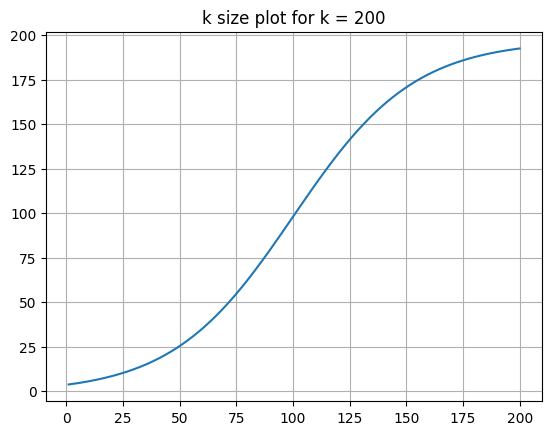

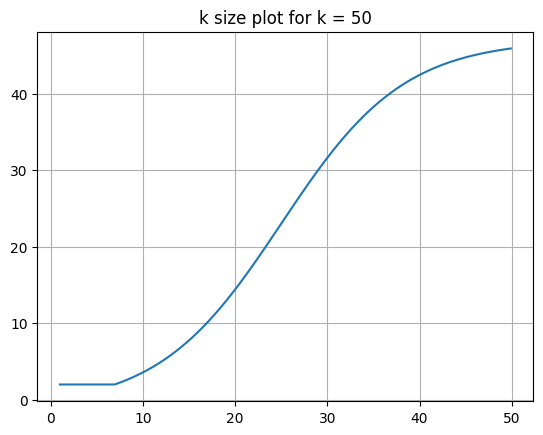

In [9]:
def calculate_k_size(x, k):
    """
    the function i make for the k size calculation is this sigmoid function
    f(x)=\ \left(k-2\right)\frac{1}{1+e^{-\frac{7.5}{k}\left(x-\frac{k}{2}\right)}}-2
    """
    b_term = np.divide(7.5, k)

    exponential_term = np.exp(-b_term*(x-k/2))
    sigmoid = np.divide(1, 1+exponential_term)

    y = (k-2)*sigmoid - 1
    # replace all values less than 2 with 2
    y = np.where(y < 2, 2, y)
    return y


# plot the sigmoid function for k = 100

x = np.arange(1, 200, 0.1)
y = calculate_k_size(x, 200)
# draw vertical line at y = 1
#plt.axhline(y=1, color='r', linestyle='-')
#plt.axvline(x=1, color='r', linestyle='-')

plt.grid()
plt.title("k size plot for k = 200")
plt.plot(x, y)
plt.show()

x = np.arange(1, 50, 0.1)
y = calculate_k_size(x, 50)
# draw vertical line at y = 1
#plt.axhline(y=1, color='r', linestyle='-')
#plt.axvline(x=1, color='r', linestyle='-')

plt.grid()
plt.title("k size plot for k = 50")
plt.plot(x, y)
plt.show()

In [10]:
def genetic_programming(num_generations, population_size, max_depth, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size, use_variable_tournament=True, silent_run=False):

    num_variables = len(variables_values[0])
    #print("Number of variables: ", num_variables)

    # Create the grammar
    genotype_list, grammar = create_n_genotypes(population_size, max_depth, num_variables)
    used_grammar = grammar
    # Initialize the genotypes
    current_genotypes = genotype_list

    # Define the statistics array to store the statistics for each generation
    stats_columns = len(index_to_variable_name)

    stats_shape = (num_generations, stats_columns)
    #print("Stats shape: ", stats_shape)
    stats = np.zeros(shape=stats_shape, dtype=np.float64)

    iterator_wrapper = tqdm(range(num_generations), desc="Generations") if not silent_run else range(num_generations)
    tournament_k_values = calculate_k_size(np.arange(1, num_generations+1, 1), num_generations)
    #print("Tournament k values: ", tournament_k_values)
    # Run the algorithm for the specified number of generations
    for generation in iterator_wrapper:
        if not silent_run:
            print(f"\n=== Generation {generation + 1} ===")
        if use_variable_tournament:
            current_tournament_size = tournament_k_values[generation]
            if not silent_run:
                print(f"Using variable tournament size: {current_tournament_size}")
        else : 
            current_tournament_size = tournament_size
        current_genotypes, current_stats = next_generation(current_genotypes, grammar, p_mutation, p_crossover, elite_percentage, variables_values, y_values, current_tournament_size, False)

        # Store the statistics for the current generation
        stats[generation, :] = current_stats

    return stats, current_genotypes, grammar

# read csv from inside synth1, called synth1-train.csv

df = pd.read_csv("synth1/synth1-train.csv", header=None)
display(df.head())

variable_matrix, y = parse_df(df)


run_stats, run_final_genotypes, used_grammar = genetic_programming(30, 50, 5, 0.2, 0.7, 0.2, variable_matrix, y, 10, True, False)


,0,1,2
0,-1.235929,-1.364106,6.515719
1,-0.602597,-0.607582,1.142835
2,2.804195,2.669195,40.677100
3,-0.226284,-2.977978,7.426363
4,2.040224,-0.592829,9.602611


Generations:   0%|          | 0/30 [00:00<?, ?it/s]


=== Generation 1 ===
Using variable tournament size: 2.0

=== Generation 2 ===
Using variable tournament size: 2.0

=== Generation 3 ===
Using variable tournament size: 2.0

=== Generation 4 ===
Using variable tournament size: 2.0

=== Generation 5 ===
Using variable tournament size: 2.0

=== Generation 6 ===
Using variable tournament size: 2.0

=== Generation 7 ===
Using variable tournament size: 2.337681816619291

=== Generation 8 ===
Using variable tournament size: 3.145321544887305

=== Generation 9 ===
Using variable tournament size: 4.107914666577978

=== Generation 10 ===
Using variable tournament size: 5.235603887108647

=== Generation 11 ===
Using variable tournament size: 6.5303597983598625

=== Generation 12 ===
Using variable tournament size: 7.982996423088997

=== Generation 13 ===
Using variable tournament size: 9.571138726348071

=== Generation 14 ===
Using variable tournament size: 11.259057975197654

=== Generation 15 ===
Using variable tournament size: 13.0

=== Gene

In [11]:
def estimate_time(repetitions=10, generations=100, popsize=100, plot_variations=False):
    estimations = 1
    execution_times = []
    if plot_variations:
        estimations = 5
    
    for _ in range(estimations):
        start_time = time.perf_counter()

        df = pd.read_csv("synth1/synth1-train.csv", header=None)

        variable_matrix, y = parse_df(df)
        for _ in range(repetitions):
            genetic_programming(1, 100, 5, 0.2, 0.7, 0.2, variable_matrix, y, 10, True, True)

        end_time = time.perf_counter()

        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        execution_times.append(elapsed_time)

    if plot_variations:
        plt.figure(figsize=(10,6))
        plt.plot(execution_times, marker='o')
        plt.title('Execution Times')
        plt.xlabel('Run')
        plt.ylabel('Time (seconds)')
        plt.legend()
        plt.show()

    elapsed_time = np.mean(execution_times)
    print(f"_________ {repetitions} runs, {generations} generations, {popsize} genotypes, 5 depth, 2 variables _________")
    print(f"Elapsed time: {elapsed_time:0.4f} seconds or {elapsed_time/60:0.4f} minutes")

estimate_time(10, 1, 10, False)

Elapsed time: 32.3027 seconds
_________ 10 runs, 1 generations, 10 genotypes, 5 depth, 2 variables _________
Elapsed time: 32.3027 seconds or 0.5384 minutes


In [12]:
start_time = time.perf_counter()


run_stats, run_final_genotypes, used_grammar = genetic_programming(100, 100, 5, 0.2, 0.7, 0.2, variable_matrix, y, 10, True, True)

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print("_________ 1 runs, 100 generations, 100 genotypes, 5 depth, 2 variables _________")
print(f"Elapsed time: {elapsed_time:0.4f} seconds or {elapsed_time/60:0.4f} minutes")

_________ 1 runs, 100 generations, 100 genotypes, 5 depth, 2 variables _________
Elapsed time: 61.3202 seconds or 1.0220 minutes


In [13]:
start_time = time.perf_counter()

run_stats, run_final_genotypes, used_grammar = genetic_programming(200, 200, 5, 0.2, 0.7, 0.2, variable_matrix, y, 10, True, True)

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print("_________ 1 runs, 200 generations, 200 genotypes, 5 depth, 2 variables _________")
print(f"Elapsed time: {elapsed_time:0.4f} seconds or {elapsed_time/60:0.4f} minutes")

_________ 1 runs, 200 generations, 200 genotypes, 5 depth, 2 variables _________
Elapsed time: 453.6047 seconds or 7.5601 minutes


Versao com elitismo


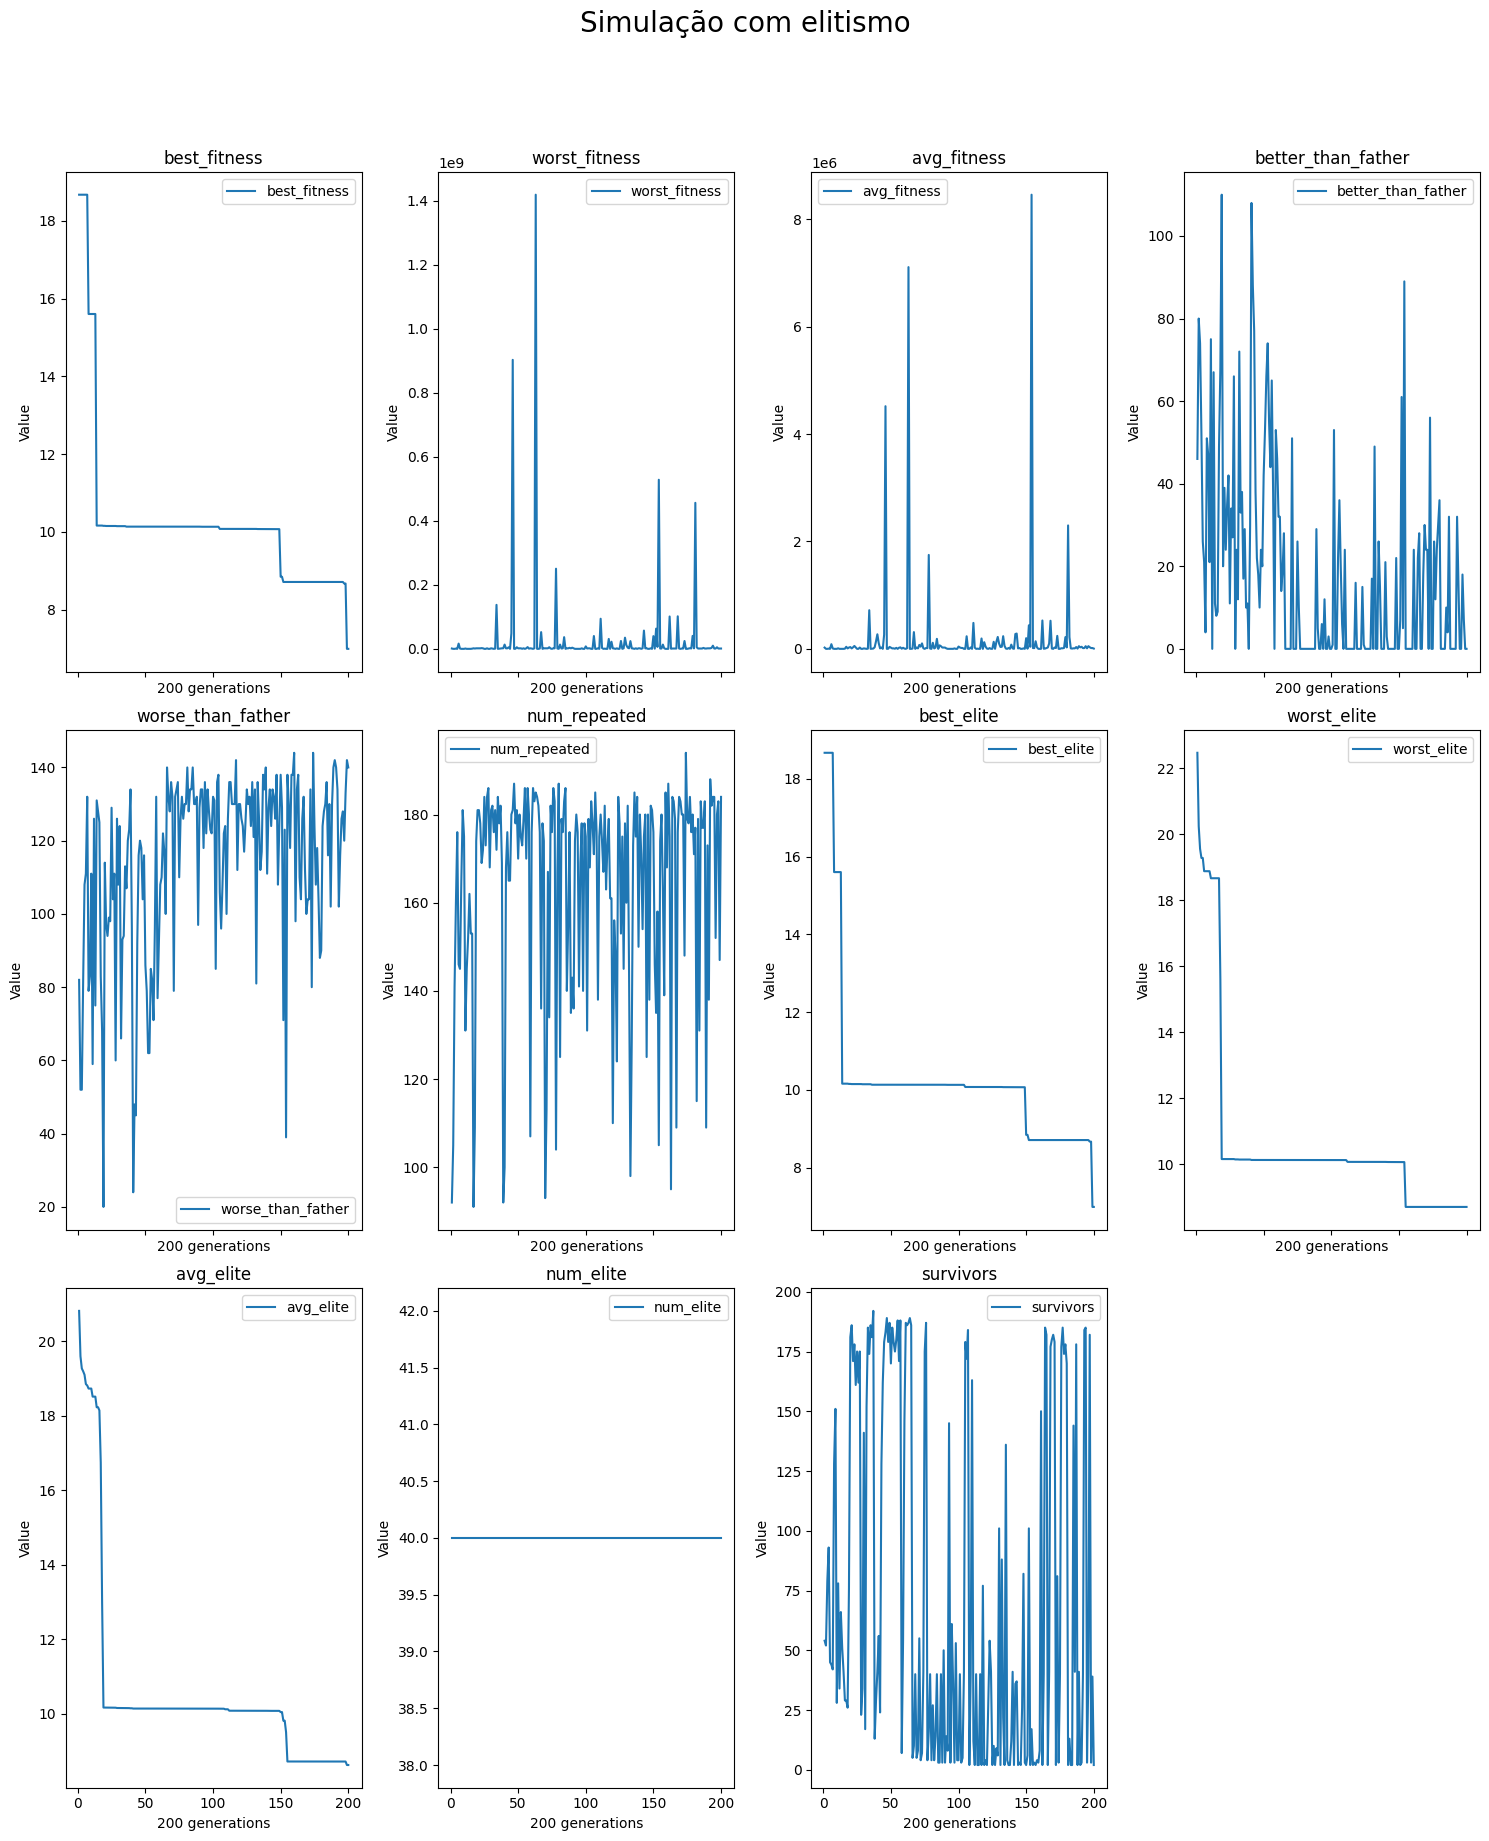

In [14]:
import math

def plot_stats(stats, index_to_variable_name, title=""):
    num_generations, num_stats = stats.shape

    num_cols = 4
    num_rows = math.ceil(num_stats / num_cols)

    # Create a subplot for each statistic in a mosaic grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows), sharex=True)
    axs = axs.flatten()  # Flatten the array to make it easier to work with

    # Plot the statistics on the corresponding subplot
    for i in range(num_stats):
        axs[i].plot(range(1, num_generations + 1), stats[:, i], label=index_to_variable_name[i])
        axs[i].set_title(index_to_variable_name[i])
        axs[i].set_xlabel(f"{num_generations} generations")
        axs[i].set_ylabel("Value")
        axs[i].legend()

    # If there are empty subplots, make them invisible
    for i in range(num_stats, len(axs)):
        axs[i].axis("off")

    # Adjust the layout of the subplots
    fig.tight_layout()
    
    if title == "":
        title = f"Run statistics for {num_generations} generations"
    fig.suptitle(title, fontsize=20, y=1.02)
    fig.subplots_adjust(top=0.93)
   
    plt.show()


run_parameters = {
    "generations": 200,
    "population_size": 25,
    "max_depth": 5,
    "p_mutation": 0.2,
    "p_crossover": 0.7,
    "elite_percentage": 0.1,
    "tournament_size": 2
}
data_save = (run_stats, run_stats, run_final_genotypes[0],run_stats[-1], used_grammar )
#cache = save_cache(cache, data_save, stats[0], "test", run_parameters)

print("Versao com elitismo")
plot_stats(run_stats, index_to_variable_name, "Simulação com elitismo")


Generations:   0%|          | 0/20 [00:00<?, ?it/s]


=== Generation 1 ===
Using variable tournament size: 2.0

=== Generation 2 ===
Using variable tournament size: 2.0

=== Generation 3 ===
Using variable tournament size: 2.0

=== Generation 4 ===
Using variable tournament size: 2.0

=== Generation 5 ===
Using variable tournament size: 2.0

=== Generation 6 ===
Using variable tournament size: 2.2836594285144143

=== Generation 7 ===
Using variable tournament size: 3.411530236382691

=== Generation 8 ===
Using variable tournament size: 4.7747834148429265

=== Generation 9 ===
Using variable tournament size: 6.332001200826745

=== Generation 10 ===
Using variable tournament size: 8.0

=== Generation 11 ===
Using variable tournament size: 9.667998799173255

=== Generation 12 ===
Using variable tournament size: 11.225216585157074

=== Generation 13 ===
Using variable tournament size: 12.588469763617308

=== Generation 14 ===
Using variable tournament size: 13.716340571485585

=== Generation 15 ===
Using variable tournament size: 14.60664367

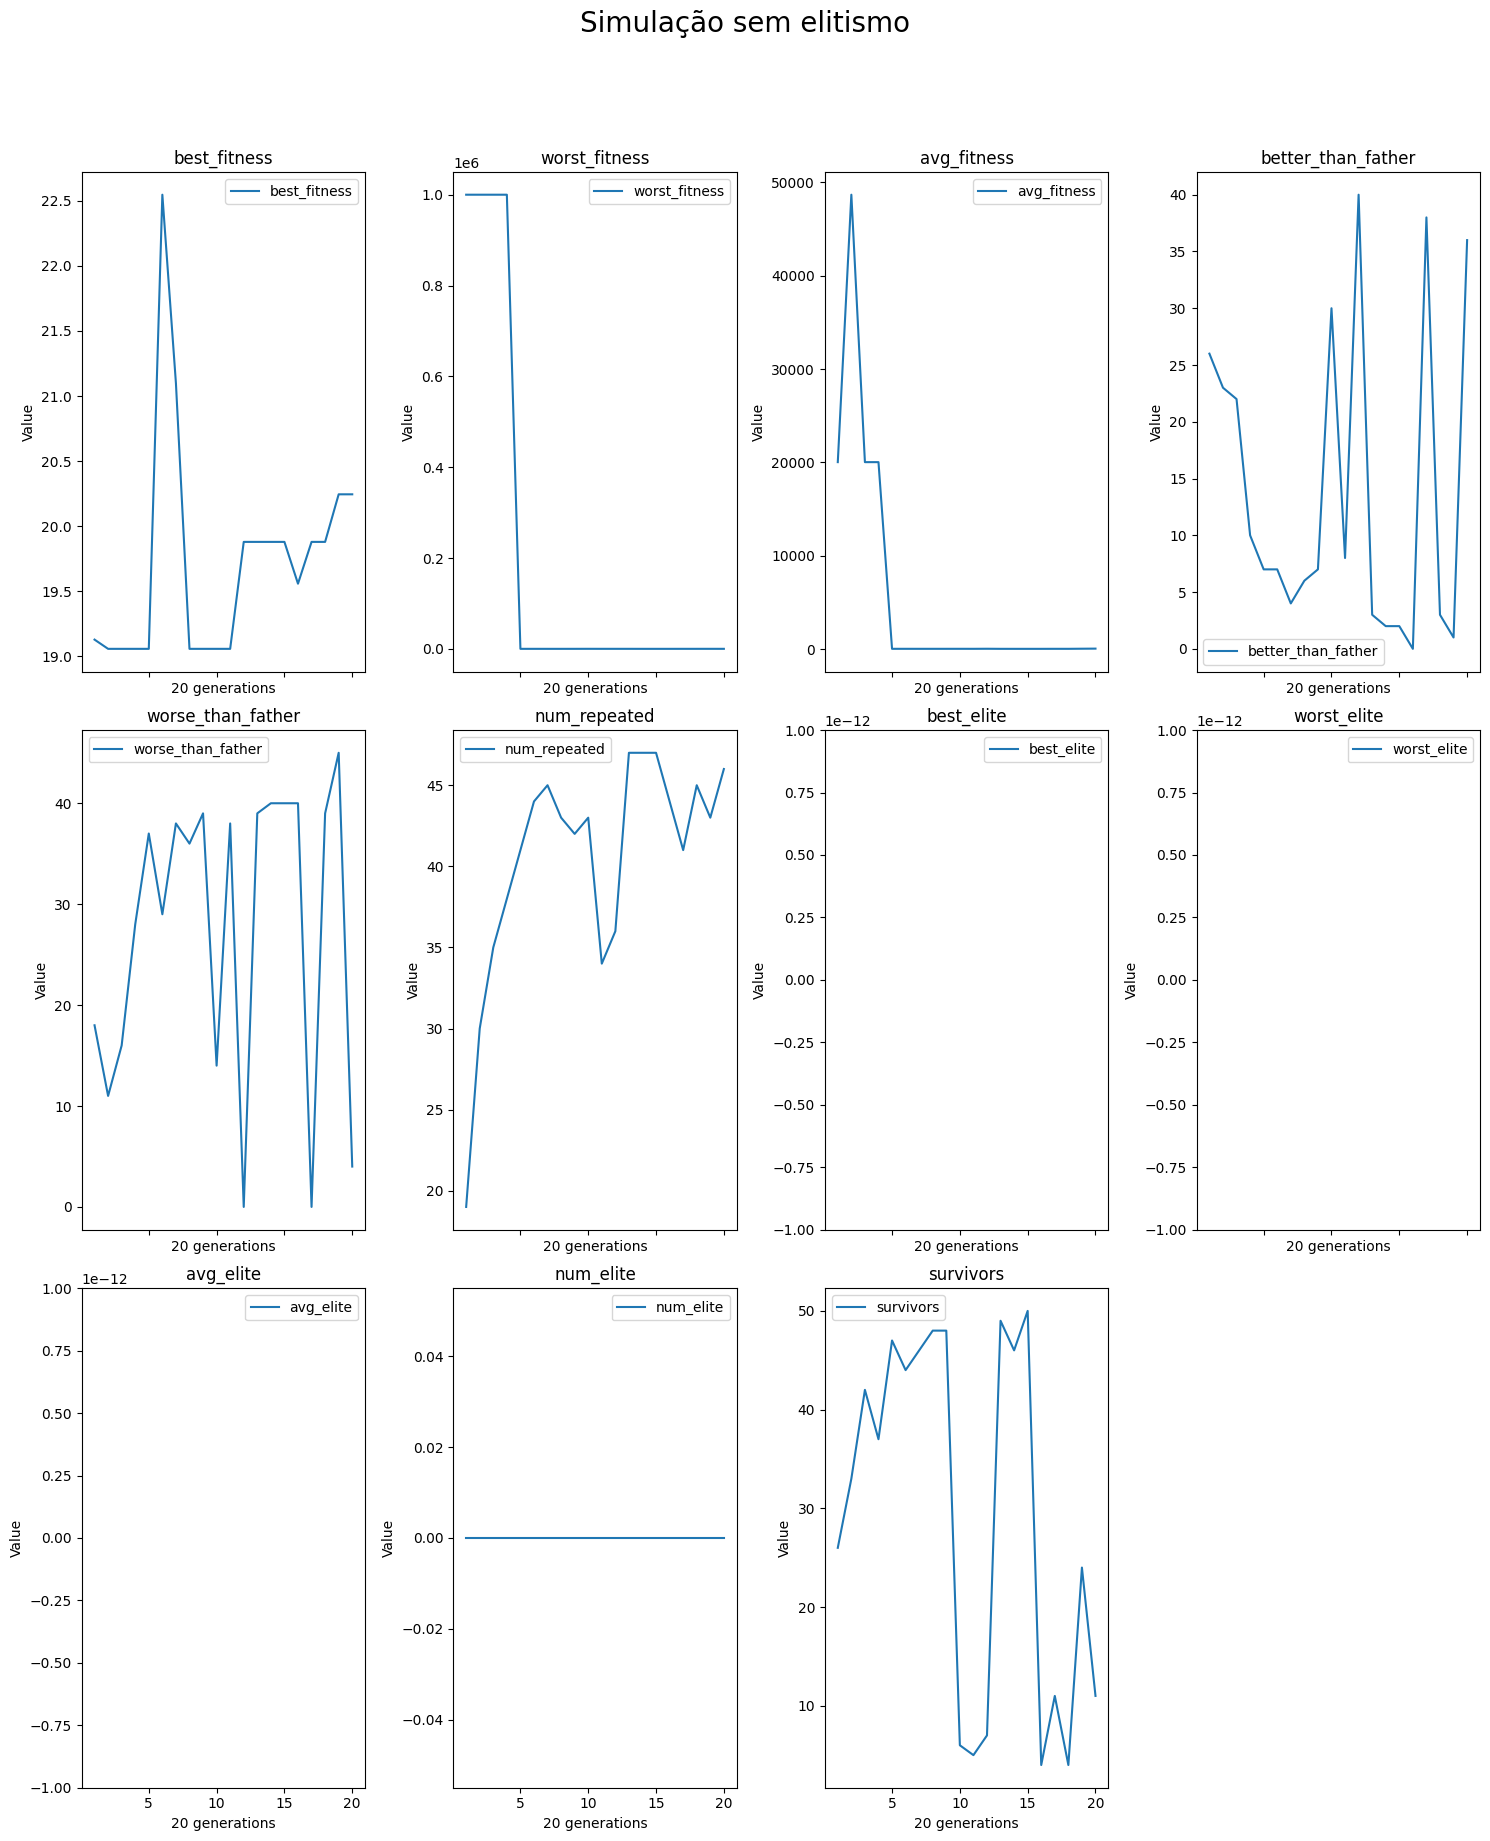

In [15]:
run_stats, run_final_genotypes, used_grammar = genetic_programming(20, 50, 5, 0.2, 0.7, 0, variable_matrix, y, 10)
plot_stats(run_stats, index_to_variable_name, "Simulação sem elitismo")

In [16]:
def plot_at_df_index(df, index, mean=False, std=False, title=""):
    row = df.iloc[index]
    if mean:
        stats_column = row["mean_stats"]
        display(row)
    else:
        stats_column = row["best_gen_stats"]
    stats_column = np.array(json.loads(stats_column))
    print(stats_column.shape)
    current_pop = row["population_size"]
    generations = row["generations"]
    p_mutation = row["p_mutation"]
    p_crossover = row["p_crossover"]
    std_last_gen = json.loads(row["std_last_gen"])
    final_fitness = row["final_fitness"]
    if title == "":
        title = f"{generations} generations, {current_pop} population, $p_m$ = {p_mutation} , $p_c$ = {p_crossover}"
    if std:
        rounded_std = round(std_last_gen[-1], 2)
        real_fitness = round(final_fitness, 2) + rounded_std
        title +="\nFitness: "+ str(real_fitness) + "$\pm$ " + str(rounded_std)

    plot_stats(stats_column, index_to_variable_name, title)

#plot_at_df_index(cache, 20, mean=False, std=True)

## Plot a cada variação de semente

Não uso mais mas deixei a função no código

In [17]:
def run_and_plot_every_iteration(max_depth=3, p_mutation=0.05, p_crossover=0.09, elite_percentage=0.1, variables_values=variable_matrix, y_values=y, tournament_size=10):

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    generations = 40
    population_size = 50
    random_iterations = 30

    best_fitness_experiment = 0
    best_fitness_value = 10000000
    base_seed = 0
    for i in tqdm(range(random_iterations), desc="Random iterations"):
            base_seed += 1
            seed(base_seed)
            np.random.seed(base_seed)

            stats, final_genotypes, used_grammar = genetic_programming(generations, population_size, max_depth, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size)
            stats_list.append(stats)
            final_genotypes_list.append(final_genotypes)
            final_used_grammar = used_grammar

            # get the best fitness from the last generation
            best_fitness_current = stats[-1, 0]
            if best_fitness_current < best_fitness_value:
                best_fitness_value = best_fitness_current
                best_fitness_experiment = i
            print("Case: ", i, " best fitness: ", best_fitness_current)
            plot_stats(stats, index_to_variable_name)

    # get the run with the best fitness overall
    best_genotypes = final_genotypes_list[best_fitness_experiment]


    # get the best genotype from the final generation of the best experiment
    fitness_list = calculate_all_fitnesses(best_genotypes, variable_matrix, y, grammar, NODE_TYPE, GENOTYPE_TYPE)

    # get the index of the best genotype
    best_index = best_n_items(fitness_list, 1)

    best_genotype = final_genotypes[best_index[0]]

    # print the best genotype
    print("Final function: ")
    copied_best = deep_copy_genotype(best_genotype, GENOTYPE_TYPE.copy())
    create_full_tree_from_genome(copied_best, final_used_grammar, NODE_TYPE, True)

    best_stats = stats_list[best_fitness_experiment]

    plot_stats(best_stats, index_to_variable_name)
#run_and_collect_data(3, 0.05, 0.9, 0.1, variable_matrix, y, 10)


# Método principal de testes

Recebe um arquivo de treinamento, parâmetros de execução e uma semente base.
Com isso, é capaz de inferir a quantidade de variáveis, criar a gramática de acordo, e instanciar n gerações do problema.

Fiz uma versão normal e uma concorrente. A concorrente não teve melhora significativa contra a normal, então para economizar recursos uso apenas ela.

minha hipótese é que talvez se dê pelo Global Interpreter Lock do python e sua restrição de paralelismo entre diferentes instâncias do intepretador python.

Experiments with  10 generations and population size 10


Random iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Stds of the problem across generations
best_fitness: 0.7635451426575819
worst_fitness: 24.62218925373891
avg_fitness: 6.938727080895659
better_than_father: 2.1999999999999997
worse_than_father: 2.90516780926679
num_repeated: 1.4696938456699067
best_elite: 0.7635451426575819
worst_elite: 0.7635451426575819
avg_elite: 0.7635451426575819
num_elite: 0.0
survivors: 2.8653097563788803


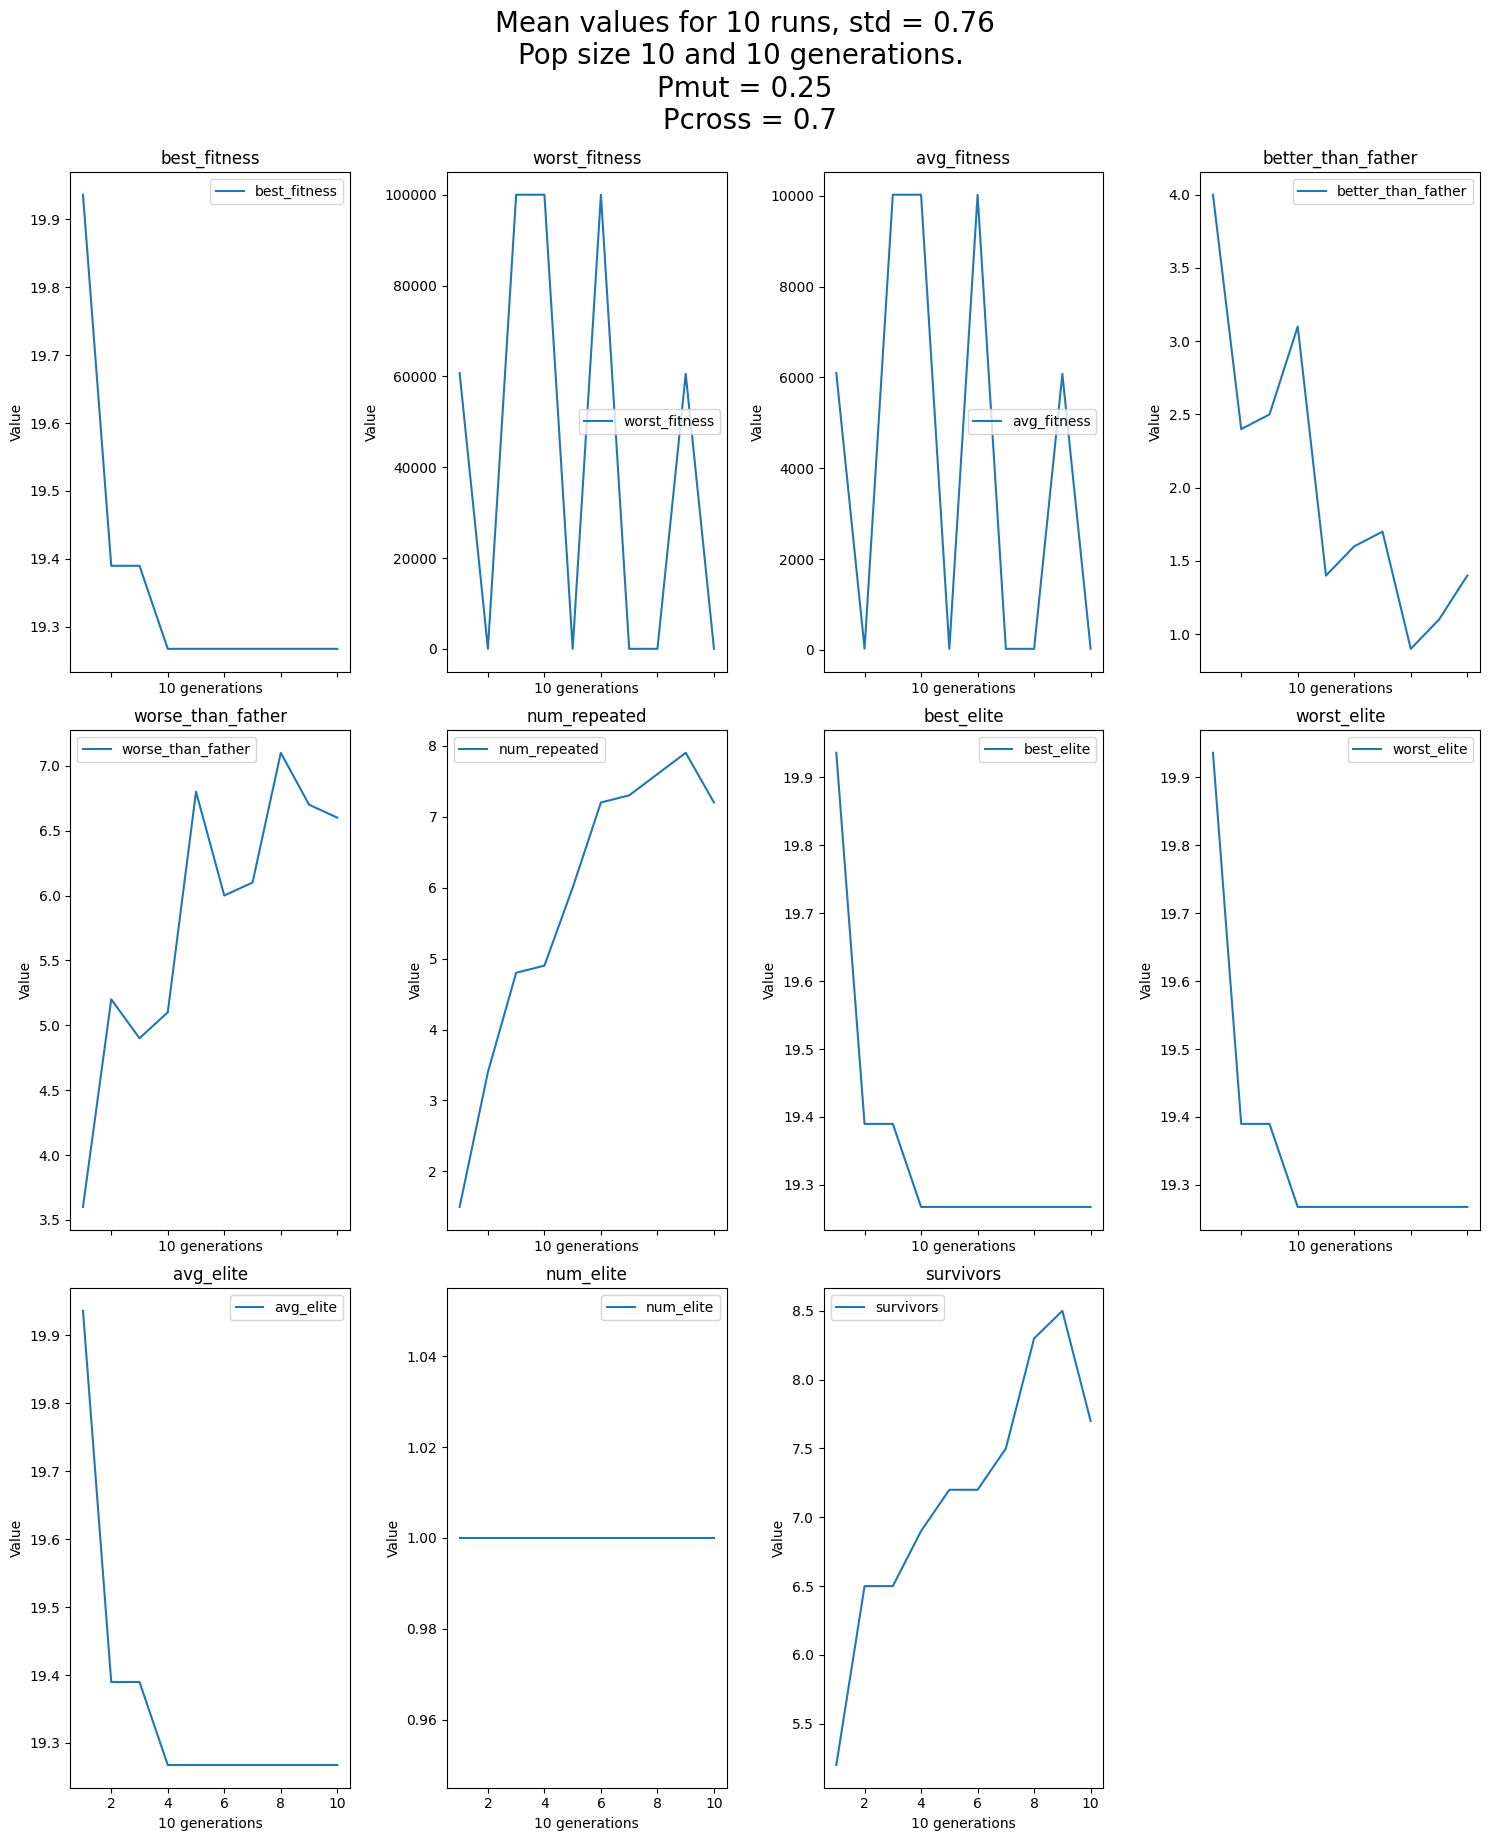

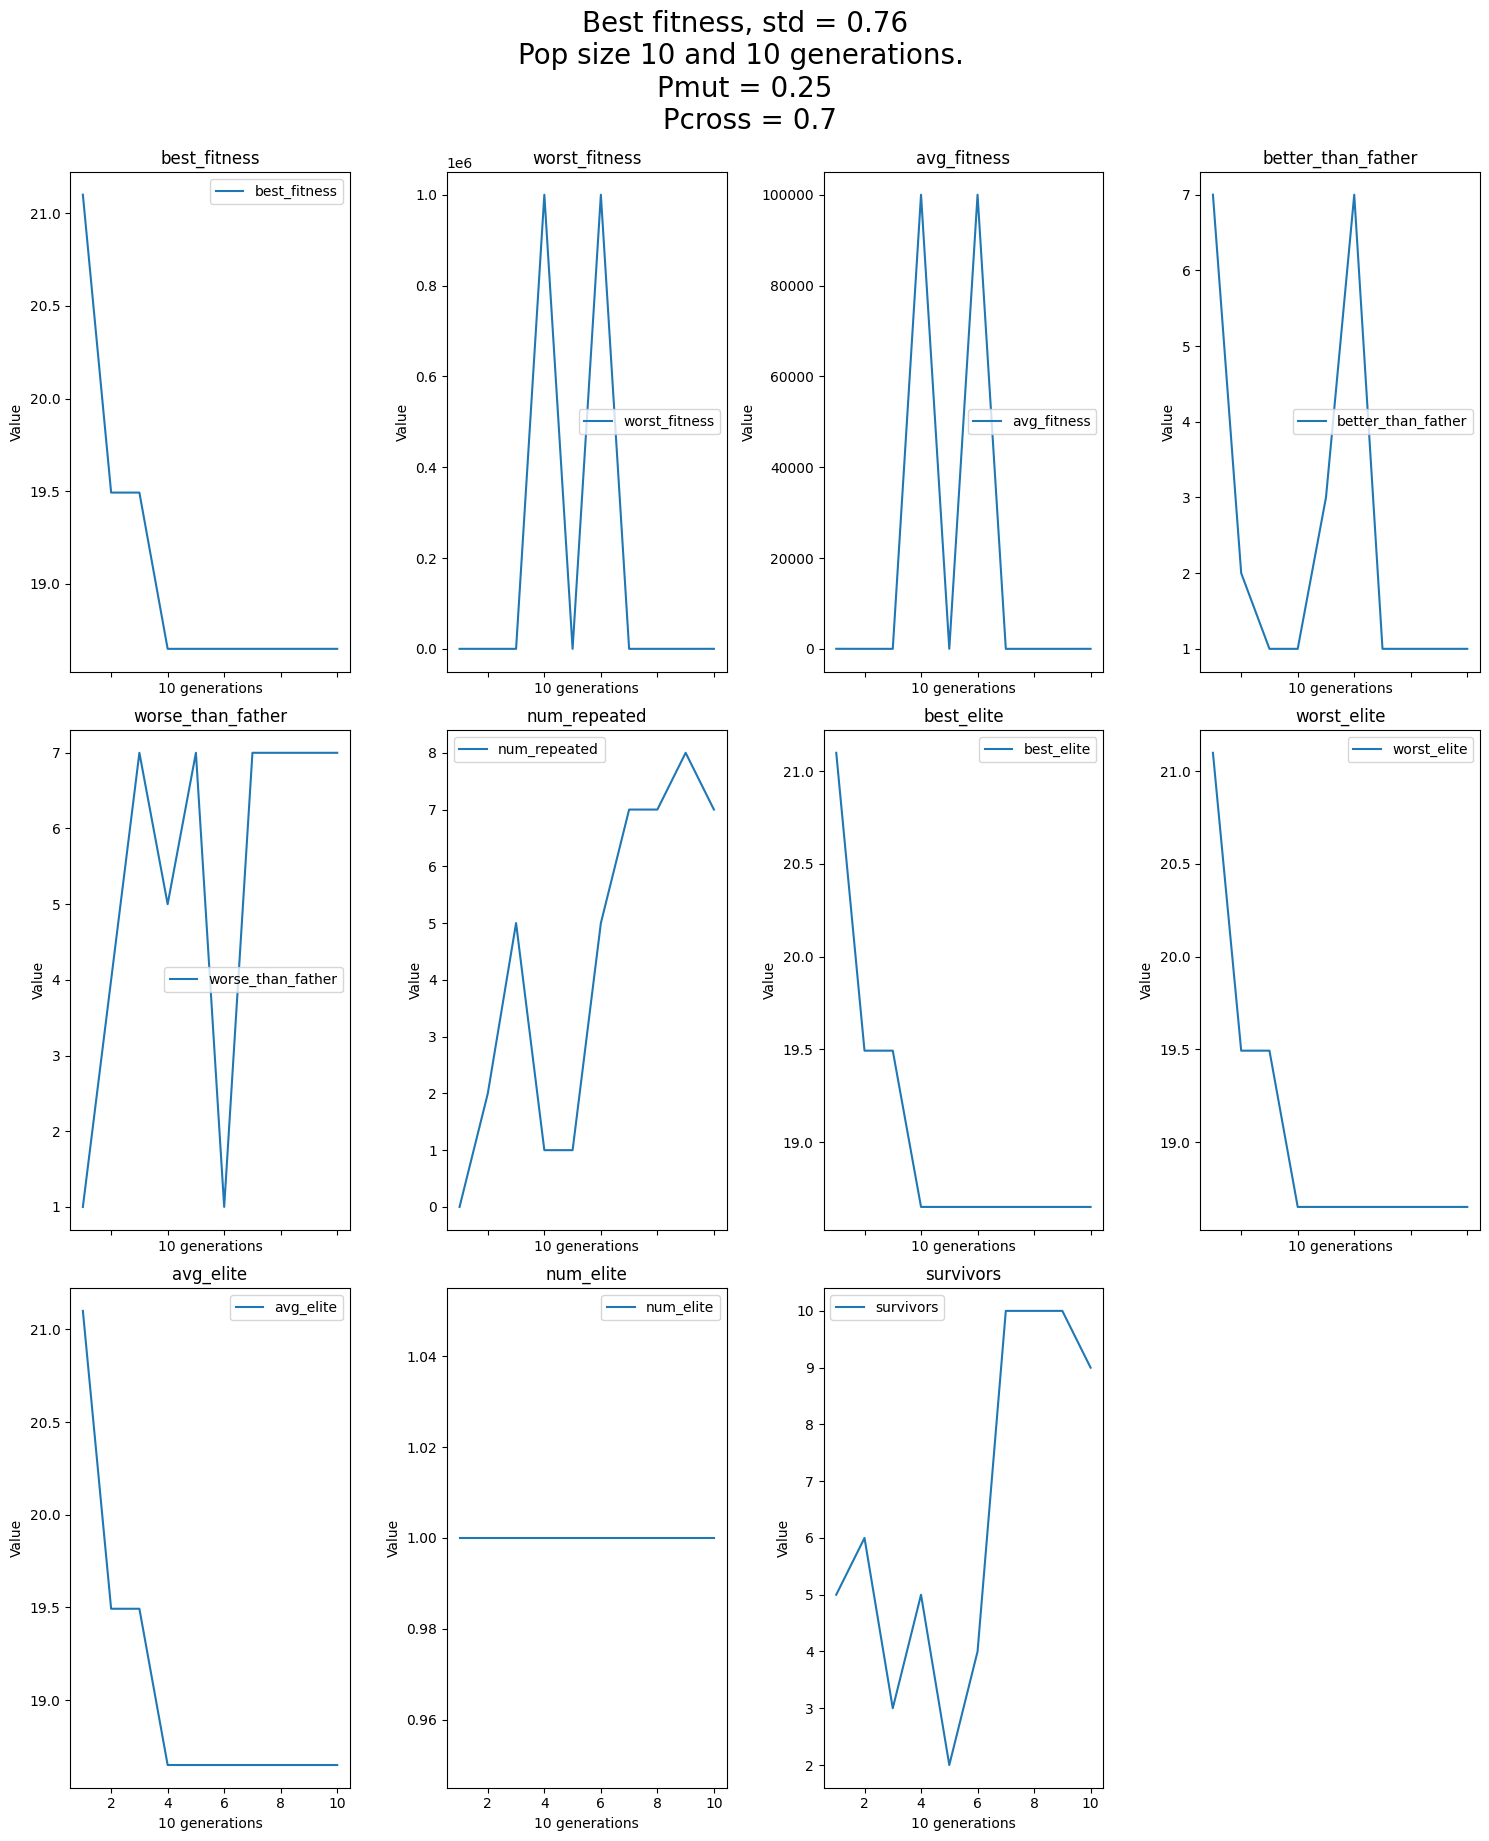

final fitness:  18.65007205659251
0.7635451426575819


In [18]:
def run_random_variations(train_filename, run_parameters, base_seed=0, change_tournament_size=True):
    df_train = pd.read_csv(train_filename, header=None)

    variable_matrix, y = parse_df(df_train)

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    print(f"Experiments with  {run_parameters['generations']} generations and population size {run_parameters['population_size']}")
    random_iterations = 10

    best_fitness_experiment = 0
    best_fitness_value = 10000000
    for i in tqdm(range(random_iterations), desc="Random iterations"):
        base_seed += 1
        seed(base_seed)
        np.random.seed(base_seed)

        run_stats, run_final_genotypes, used_grammar = genetic_programming(run_parameters['generations'], run_parameters['population_size'], run_parameters["max_depth"], run_parameters["p_mutation"], run_parameters["p_crossover"], run_parameters["elite_percentage"], variable_matrix, y, run_parameters["tournament_size"], change_tournament_size, True)
        stats_list.append(run_stats)
        final_genotypes_list.append(run_final_genotypes)
        final_used_grammar = used_grammar

        # get the best fitness from the last generation
        best_fitness_current = run_stats[-1, 0]
        if best_fitness_current < best_fitness_value:
            best_fitness_value = best_fitness_current
            best_fitness_experiment = i


    mean_stats = np.mean(stats_list, axis=0)

    stds_across_stats = np.std(stats_list, axis=0)
    std_final_gen = round(stds_across_stats[-1, 0], 2)
    print("Stds of the problem across generations")
    for i in range(len(index_to_variable_name)):
        print(f"{index_to_variable_name[i]}: {stds_across_stats[-1, i]}")


    title = f"Pop size {run_parameters['population_size']} and {run_parameters['generations']} generations. \nPmut = {run_parameters['p_mutation']}\n Pcross = {run_parameters['p_crossover']}"
    


    plot_stats(mean_stats, index_to_variable_name, f"Mean values for {random_iterations} runs, std = {std_final_gen}\n{title}")
    plot_stats(stats_list[best_fitness_experiment], index_to_variable_name, f"Best fitness, std = {std_final_gen}\n{title}")

    return mean_stats, stats_list[best_fitness_experiment],  final_genotypes_list[best_fitness_experiment], stds_across_stats, final_used_grammar

from multiprocessing import Pool


def run_iteration(i, base_seed, run_parameters, variable_matrix, y, change_tournament_size):
    base_seed = base_seed + i
    seed(base_seed)
    np.random.seed(base_seed)

    run_stats, run_final_genotypes, used_grammar = genetic_programming(run_parameters['generations'], run_parameters['population_size'], run_parameters["max_depth"], run_parameters["p_mutation"], run_parameters["p_crossover"], run_parameters["elite_percentage"], variable_matrix, y, run_parameters["tournament_size"], change_tournament_size, True)
    return run_stats, run_final_genotypes, used_grammar


# Não uso pq o speedup é minimo, não melhora muito o tempo de execução, q é em torno de 12minutos
# talvez se dê pelo problema com o Global Interpreter Lock do python
def run_random_variations_concurrent(train_filename, run_parameters, base_seed=0, change_tournament_size=True):
    df_train = pd.read_csv(train_filename, header=None)

    variable_matrix, y = parse_df(df_train)

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    print(f"Experiments with  {run_parameters['generations']} generations and population size {run_parameters['population_size']}")
    random_iterations = 10

    best_fitness_experiment = 0
    best_fitness_value = 10000000

    with Pool() as p:
        results = p.map(run_iteration, [(i, base_seed, run_parameters, variable_matrix, y, change_tournament_size) for i in range(random_iterations)])

    #results = []
    #for i in range(random_iterations):
    #    results.append(run_iteration(i, base_seed, run_parameters, variable_matrix, y, change_tournament_size))


    stats_list = [result[0] for result in results]
    final_genotypes_list = [result[1] for result in results]
    final_used_grammar = results[-1][2] 
    mean_stats = np.mean(stats_list, axis=0)

    stds_across_stats = np.std(stats_list, axis=0)

    print("Stds of the problem across generations")
    for i in range(len(index_to_variable_name)):
        print(f"{index_to_variable_name[i]}: {stds_across_stats[-1, i]}")

    # get the best fitness (oth index) from the last generation
    fitness_list = [stats[-1, 0] for stats in stats_list]
    for i, fitness in enumerate(fitness_list):
        if fitness < best_fitness_value:
            best_fitness_value = fitness
            best_fitness_experiment = i
    title = f"Pop size {run_parameters['population_size']} and {run_parameters['generations']} generations. \nPmut = {run_parameters['p_mutation']}\n Pcross = {run_parameters['p_crossover']}"
    
    plot_stats(mean_stats, index_to_variable_name, f"Mean values for {random_iterations} runs - {title}")
    plot_stats(stats_list[best_fitness_experiment], index_to_variable_name, f"Best fitness - {title}")

    return mean_stats, stats_list[best_fitness_experiment],  final_genotypes_list[best_fitness_experiment], stds_across_stats, final_used_grammar
        



run_parameters = {
    "generations": 10,
    "population_size": 10,
    "max_depth": 5,
    "p_mutation": 0.25,
    "p_crossover": 0.7,
    "elite_percentage": 0.1,
    "tournament_size": 2
}

agg, best_gen_stats, best_genotypes, stds, grammar = run_random_variations("synth1/synth1-train.csv", run_parameters, 0)

data_cache = (agg, best_gen_stats, best_genotypes, stds, grammar)
final_fitness = best_gen_stats[-1, 0]
print("final fitness: ", final_fitness)
final_std = stds[-1][0]
print(final_std)
#cache = save_cache(cache, data_cache, final_fitness, "synth1/synth1-train.csv", run_parameters)


In [19]:
files = ["synth1/synth1-train.csv", "synth2/synth2-train.csv", "concrete/concrete-train.csv"]
test_files = ["synth1/synth1-test.csv", "synth2/synth2-test.csv", "concrete/concrete-test.csv"]


for i, file in enumerate(files):
    
    test_file = test_files[i]
 # variate mutation rate by 0.05, until 0.9
    for p_mut in tqdm(range(2, 50, 5), desc=f"Experiments for {test_file}"):
        
        mutation_rate = p_mut / 100
        crossover_rate = 1 - mutation_rate - 0.05
        run_parameters = {
            "generations": 200,
            "population_size": 200,
            "max_depth": 5,
            "p_mutation": mutation_rate,
            "p_crossover": crossover_rate,
            "elite_percentage": 0.1,
            "tournament_size": -1
        }
        print("NEW PARAMETERS________________")
        print(f"pmut = {run_parameters['p_mutation']}, pcross = {run_parameters['p_crossover']}, elite = {run_parameters['elite_percentage']}")

        returned_data = load_cache(cache, file, run_parameters)
        if returned_data is not None:
            print("Found in cache! Skipping...")
            mean_stats, best_gen_stats, stds, grammar  = returned_data
        else:
            mean_stats, best_gen_stats, best_genotypes, stds, grammar  = run_random_variations(file, run_parameters, 0, True)
            data_to_cache = (mean_stats, best_gen_stats, best_genotypes, stds, grammar)
            
            final_fitness = mean_stats[-1, 0]
            print("FINAL MEAN FITNESS: ", final_fitness)
            print("Saving to cache!")
            cache = save_cache(cache, data_to_cache, final_fitness, file, run_parameters)

Experiments for synth1/synth1-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.37, pcross = 0.58, elite = 0.1
Loaded from cache
Found in cache! Skippi

Experiments for synth2/synth2-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.37, pcross = 0.58, elite = 0.1
Loaded from cache
Found in cache! Skippi

Experiments for concrete/concrete-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.37, pcross = 0.58, elite = 0.1
Loaded from cache
Found in cache! Skippi

In [20]:
files = ["concrete/concrete-train.csv"]
test_files = ["concrete/concrete-test.csv"]


for i, file in enumerate(files):
    test_file = test_files[i]
    # variate mutation rate by 0.05, until 0.9
    for p_mut in tqdm(range(2, 50, 5), desc=f"Experiments for {test_file}"):
        
        mutation_rate = p_mut / 100
        crossover_rate = 1 - mutation_rate - 0.05
        run_parameters = {
            "generations": 500,
            "population_size": 500,
            "max_depth": 6,
            "p_mutation": mutation_rate,
            "p_crossover": crossover_rate,
            "elite_percentage": 0.1,
            "tournament_size": -1
        }
        print("NEW PARAMETERS________________")
        print(f"pmut = {run_parameters['p_mutation']}, pcross = {run_parameters['p_crossover']}, elite = {run_parameters['elite_percentage']}")

        returned_data = load_cache(cache, file, run_parameters)
        if returned_data is not None:
            print("Found in cache! Skipping...")
            mean_stats, best_gen_stats, stds, grammar  = returned_data
        else:
            mean_stats, best_gen_stats, best_genotypes, stds, grammar  = run_random_variations(file, run_parameters, 0, True)
            data_to_cache = (mean_stats, best_gen_stats, best_genotypes, stds, grammar)
            
            final_fitness = mean_stats[-1, 0]
            print("FINAL MEAN FITNESS: ", final_fitness)
            print("Saving to cache!")
            cache = save_cache(cache, data_to_cache, final_fitness, file, run_parameters)

Experiments for concrete/concrete-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Experiments with  500 generations and population size 500


Random iterations:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_test_fitness_per_genome(genotype_list, grammar, test_filename="synth1/synth1-train.csv"):
    df_test = pd.read_csv(test_filename, header=None)

    variable_matrix, y = parse_df(df_test)
    fitness_list = calculate_all_fitnesses(genotype_list, variable_matrix, y, grammar, NODE_TYPE, GENOTYPE_TYPE)

    print("Genotypes: ", len(genotype_list))
    for i, g in enumerate(genotypes):
        print(f"For the {i}th genotype, function is", sep=" ")
        copied_g = deep_copy_genotype(g, GENOTYPE_TYPE.copy())
        create_full_tree_from_genome(copied_g, grammar, NODE_TYPE, True)
    print(fitness_list)
    x_values = range(len(fitness_list))
    y_values = np.clip(fitness_list, None, 100)
    mean_value = np.mean(y_values)

    plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
    plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

    plt.xlabel('Genotype Index')
    plt.ylabel('Fitness')
    plt.title('Comparison with test case')
    plt.ylim(bottom=0)
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.show()

copy_best_genotypes = best_genotypes
print(grammar['<var>'])
plot_test_fitness_per_genome(copy_best_genotypes, grammar, "concrete/concrete-test.csv")

# Esse método não funcionou nessa run pq impedi execução da célula anterior, então a gramática está da synth1 invés da concrete
# porém ele funcionava comparando os genótipos e o dataset de teste e plottando um barplot da fitness